# High Performance Python #
## Comparision Function ##

In [1]:
def perf_comp_data(func_list, data_list, rep = 3, number = 1):
    from timeit import repeat
    res_list = {}
    for name in enumerate(func_list):
        stmt = name[1] + '(' + data_list[name[0]] + ')'
        setup = "from __main__ import " + name[1] + ", " + data_list[name[0]]
        results = repeat(stmt = stmt, setup = setup, repeat = rep, number = number)
        res_list[name[1]] = sum(results) / rep
    res_sort = sorted(res_list.iteritems(), key = lambda (k, v) : (v, k))
    for item in res_sort:
        rel = item[1] / res_sort[0][1]
        print 'function: ' + item[0] + ', av. time sec: %9.5f' % item[1] + 'relative: %6.1f' % rel

## Calculation ##

In [2]:
from math import *
def f(x):
    return abs(cos(x)) ** 0.5 + sin(2 + 3 * x)

In [3]:
I = 5
a_py = range(I)

In [4]:
def f1(a):
    res = []
    for x in a:
        res.append(f(x))
    return res

In [5]:
def f2(a):
    return [f(x) for x in a]

In [6]:
def f3(a):
    ex = 'abs(cos(x)) ** 0.5 + sin(2 + 3 * x)'
    return [eval(ex) for x in a]

In [7]:
import numpy as np
a_np = np.arange(I)
def f4(a):
    return (np.abs(np.cos(a)) ** 0.5 + np.sin(2 + 3 * a))

In [8]:
import numexpr as ne
def f5(a):
    ex = 'abs(cos(a)) ** 0.5 + sin(2 + 3 * a)'
    ne.set_num_threads(1)
    return ne.evaluate(ex)

In [9]:
def f6(a):
    ex = 'abs(cos(a)) ** 0.5 + sin(2 + 3 * a)'
    ne.set_num_threads(16)
    return ne.evaluate(ex)

## Compare speed ##
** Requires INTEL MKL library for multi-thread calculation, shit, will come back later **

In [10]:
func_list = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6']
data_list = ['a_py', 'a_py', 'a_py', 'a_np', 'a_np', 'a_np']

In [11]:
#perf_comp_data(func_list, data_list)

# ** Memory Placement and Performance ** #

In [12]:
np.zeros((3, 3), dtype = np.float64, order = 'C')

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

## How column/row wise arrangement will affect performance? ##

In [13]:
x = np.random.standard_normal((3, 1500000))
C = np.array(x, order = 'C')
F = np.array(x, order = 'F')
x = 0.0

In [14]:
%timeit C.sum(axis = 0)

100 loops, best of 3: 6.38 ms per loop


In [15]:
%timeit C.sum(axis = 1)

100 loops, best of 3: 2.02 ms per loop


In [16]:
%timeit F.std(axis = 0)

10 loops, best of 3: 72.1 ms per loop


In [17]:
%timeit F.std(axis = 1)

10 loops, best of 3: 90.9 ms per loop


In [18]:
C = 0.0; F = 0.0

## Parallel Calculation ##

Start a cluster:

ipcluster start

Use it from Python:

import os

import ipyparallel as ipp

rc = ipp.Client()
ar = rc[:].apply_async(os.getpid)
pid_map = ar.get_dict()

## Monte carlo estimation function of euro call option ##

In [19]:
def bsm_mcs_valuation(strike):
    import numpy as np
    S0 = 100.; T = 1.0; r = 0.05; vola = 0.2
    M = 50; I = 2000
    dt = T / M
    rand = np.random.standard_normal((M + 1, I))
    S = np.zeros((M + 1, I)); S[0] = S0
    for t in range(1, M + 1):
        S[t] = S[t - 1] * np.exp((r - .5 * vola ** 2) *dt + vola * np.sqrt(dt) * rand[t])
    value = (np.exp(-r * T) * np.sum(np.maximum(S[-1] - strike, 0)) / I)
    return value

** Series Calculation **

In [20]:
import numpy as np
def seq_value(n):
    strikes = np.linspace(80, 120, n)
    option_values = list()
    for strike in strikes:
        option_values.append(bsm_mcs_valuation(strike))
    return strikes, option_values

In [21]:
n = 100
%time strikes, option_values = seq_value(n)

CPU times: user 676 ms, sys: 0 ns, total: 676 ms
Wall time: 678 ms


In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

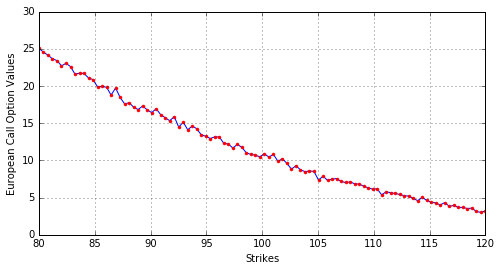

In [23]:
plt.figure(figsize = (8, 4))
plt.plot(strikes, option_values, 'b')
plt.plot(strikes, option_values, 'r.')
plt.grid(True)
plt.xlabel('Strikes')
plt.ylabel('European Call Option Values')

** Parallel Calculation **

In [24]:
from ipyparallel import Client

In [25]:
c = Client(profile = 'default')
view = c.load_balanced_view()

In [26]:
def par_value(n):
    strikes = np.linspace(80, 120, n)
    option_values = list()
    for strike in strikes:
        value = view.apply_async(bsm_mcs_valuation, strike)
        option_values.append(value)
    c.wait(option_values)
    return strikes, option_values

In [27]:
% time strikes, option_values_obj = par_value(n)

CPU times: user 156 ms, sys: 20 ms, total: 176 ms
Wall time: 488 ms


In [28]:
option_values_obj[0].metadata

{'after': [],
 'completed': datetime.datetime(2016, 7, 3, 14, 20, 7, 776390),
 'data': {},
 'engine_id': 1,
 'engine_uuid': u'f7fce65c-2fe4-472a-94af-3166f732988e',
 'error': None,
 'execute_input': None,
 'execute_result': None,
 'follow': [],
 'msg_id': u'1ae86352-e132-4b62-a9c1-b14594c3c450',
 'outputs': [],
 'received': datetime.datetime(2016, 7, 3, 14, 20, 7, 794184),
 'started': datetime.datetime(2016, 7, 3, 14, 20, 7, 721032),
 'status': u'ok',
 'stderr': '',
 'stdout': '',
 'submitted': datetime.datetime(2016, 7, 3, 14, 20, 7, 711951)}

In [29]:
option_values_obj[0].result()

24.376380326841083

In [30]:
option_values_par = list()
for option in option_values_obj:
    option_values_par.append(option.result())

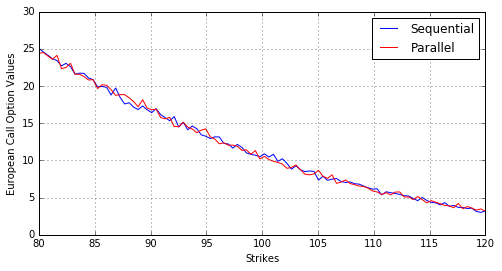

In [31]:
plt.figure(figsize = (8, 4))
plt.plot(strikes, option_values, 'b', label = 'Sequential')
plt.plot(strikes, option_values_par, 'r', label = 'Parallel')
plt.grid(True)
plt.legend(loc = 0)
plt.xlabel('Strikes')
plt.ylabel('European Call Option Values')

In [32]:
n = 50
func_list = ['seq_value', 'par_value']
data_list = 2 * ['n']
perf_comp_data(func_list, data_list)

function: par_value, av. time sec:   0.21879relative:    1.0
function: seq_value, av. time sec:   0.33955relative:    1.6


** Multi-processing **

In [33]:
import multiprocessing as mp

In [34]:
import math
def simulate_geometric_brownian_motion(p):
    M, I = p
    S0 = 100; r = 0.05; sigma = 0.2; T = 1.0
    dt = T / M
    paths = np.zeros((M + 1, I))
    paths[0] = S0
    for t in range(1, M + 1):
        paths[t] = paths[t - 1] * np.exp((r - .5 * sigma ** 2) * dt +
                                        sigma * math.sqrt(dt) * np.random.standard_normal(I))
    return paths

In [35]:
print simulate_geometric_brownian_motion((5 , 2))

[[ 100.          100.        ]
 [ 102.17861569   95.40474894]
 [ 101.74357579   88.278418  ]
 [  98.32302871   74.84167932]
 [  91.58666481   72.38287205]
 [  87.14069335   75.20126483]]


In [36]:
I = 10000
M = 100
t = 100
from time import time
times = list()
for w in range(1, 5):
    t0 = time()
    pool = mp.Pool(processes = w)
    result = pool.map(simulate_geometric_brownian_motion, t * [(M, I), ])
    times.append(time() - t0)

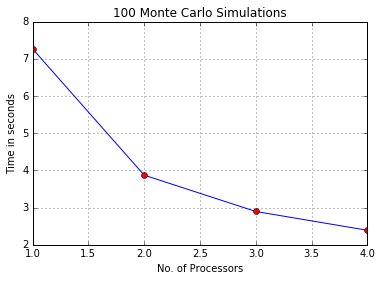

In [37]:
plt.plot(range(1, 5), times)
plt.plot(range(1, 5), times, 'ro')
plt.grid(True)
plt.xlabel('No. of Processors')
plt.ylabel('Time in seconds')
plt.title('%d Monte Carlo Simulations' % t)

## Dynamic Compilation ##

In [38]:
from math import cos, log
def f_py(I, J):
    res = 0
    for i in range(I):
        for j in range(J):
            res += int(cos(log(1)))
    return res

In [39]:
I, J = 5000, 5000
%time f_py(I, J)

CPU times: user 8.48 s, sys: 1.11 s, total: 9.59 s
Wall time: 7.7 s


25000000

In [40]:
def f_np(I, J):
    a = np.ones((I, J), dtype = np.float64)
    print a.nbytes
    return int(np.sum(np.cos(np.log(a)))), a

In [41]:
%time f_np(I, J)

200000000
CPU times: user 296 ms, sys: 36 ms, total: 332 ms
Wall time: 327 ms


(25000000, array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ..., 
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.]]))

In [42]:
import numba as nb

In [43]:
f_nb = nb.jit(f_py)

In [44]:
%time f_nb(I, J)

CPU times: user 112 ms, sys: 20 ms, total: 132 ms
Wall time: 139 ms


25000000

In [45]:
func_list = ['f_py', 'f_np', 'f_nb']
data_list = 3 * ['I, J']

In [46]:
perf_comp_data(func_list, data_list)

200000000
200000000
200000000
function: f_nb, av. time sec:   0.00000relative:    1.0
function: f_np, av. time sec:   0.32047relative: 139047.7
function: f_py, av. time sec:   7.79146relative: 3380663.8


## 二项式期权定价 ##

In [47]:
S0 = 100.
T = 1.
r = .05
vola = .2

M = 1000
dt = T / M
df = exp(-r * dt)
u = exp(vola * sqrt(dt))
d = 1 / u
q = (exp(r * dt) - d) / (u - d)

In [48]:
def binomial_py(strike):
    S = np.zeros((M + 1, M + 1), dtype = np.float64)
    S[0, 0] = S0
    z1 = 0
    for j in xrange(1, M + 1, 1):
        z1 = z1 + 1
        for i in xrange(z1 + 1):
            S[i, j] = S[0, 0] * (u ** j) * (d ** (i * 2))
    
    iv = np.zeros((M + 1, M + 1), dtype = np.float64)
    z2 = 0
    for j in xrange(0, M + 1, 1):
        for i in xrange(z2 + 1):
            iv[i, j] = max(S[i, j] - strike, 0)
        z2 = z2 + 1
    
    pv = np.zeros((M + 1, M + 1), dtype = np.float64)
    pv[:, M] = iv[:, M]
    z3 = M + 1
    for j in xrange(M - 1, -1, -1):
        z3 = z3 - 1
        for i in xrange(z3):
            pv[i, j] = (q * pv[i, j + 1] + (1 - q) * pv[i + 1, j + 1]) * df
    
    return pv[0, 0]

In [49]:
%time round(binomial_py(100), 3)

CPU times: user 1.27 s, sys: 180 ms, total: 1.45 s
Wall time: 1.21 s


10.449

In [50]:
%time round(bsm_mcs_valuation(100), 3)

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 11.7 ms


10.069

In [51]:
def binominal_np(strike):
    mu = np.arange(M + 1)
    mu = np.resize(mu, (M + 1, M + 1))
    md = np.transpose(mu)
    mu = u ** (mu - md)
    md = d ** md
    S = S0 * mu * md
    
    pv = np.maximum(S - strike, 0)
    z = 0
    for t in range(M - 1, -1, -1):
        pv[0 : M - z, t] = (q * pv[0 : M - z, t + 1] + (1 - q) * pv[1 : M - z + 1, t + 1]) * df
        z += 1
    return pv[0, 0]

In [52]:
M = 1000
%time round(binominal_np(100), 3)

CPU times: user 164 ms, sys: 0 ns, total: 164 ms
Wall time: 159 ms


10.449

In [53]:
binominal_nb = nb.jit(binomial_py)
%time round(binominal_nb(100), 3)

CPU times: user 376 ms, sys: 24 ms, total: 400 ms
Wall time: 372 ms


10.449

In [54]:
func_list = ['binomial_py', 'binominal_nb', 'binominal_np']
K = 100
data_list = 3 * ['K']
perf_comp_data(func_list, data_list)

function: binominal_nb, av. time sec:   0.02884relative:    1.0
function: binominal_np, av. time sec:   0.15772relative:    5.5
function: binomial_py, av. time sec:   1.18326relative:   41.0


## Static Compilation  Cython ##

In [55]:
def f_py(I, J):
    res = 0
    for i in range(I):
        for j in range( J * I):
            res += 1
    return res

In [56]:
I, J = 500, 500
%time f_py(I, J)

CPU times: user 5.05 s, sys: 0 ns, total: 5.05 s
Wall time: 4.99 s


125000000

## Cython

In [57]:
import pyximport
pyximport.install()

(None, <pyximport.pyximport.PyxImporter at 0x7f951f0cded0>)

In [58]:
import sys
sys.path.append('data/')

In [59]:
from nested_loop import f_cy

In [60]:
%time res = f_cy(I, J)

CPU times: user 148 ms, sys: 0 ns, total: 148 ms
Wall time: 147 ms


In [61]:
res

125000000.0

## CythonMagic ##

In [62]:
%load_ext Cython

In [63]:
%%cython
def f_cymagic(int I, int J):
    cdef double res = 0
    for i in range(I):
        for j in range(I * J):
            res += 1
    return res

In [64]:
%time res = f_cymagic(I, J)

CPU times: user 116 ms, sys: 0 ns, total: 116 ms
Wall time: 115 ms


In [65]:
f_nb = nb.jit(f_py)

In [66]:
%time res = f_nb(I, J)

CPU times: user 56 ms, sys: 4 ms, total: 60 ms
Wall time: 56.4 ms


In [67]:
func_list = ['f_py', 'f_nb', 'f_cy', 'f_cymagic']
I, J = 500, 500
data_list = 4 * ['I, J']

In [68]:
perf_comp_data(func_list, data_list)

function: f_nb, av. time sec:   0.00000relative:    1.0
function: f_cy, av. time sec:   0.11338relative: 43232.6
function: f_cymagic, av. time sec:   0.11925relative: 45468.3
function: f_py, av. time sec:   5.13749relative: 1958926.0
